## Фаза1. Неделя 1. Среда


### A/B - тесты

In [275]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline  
import warnings
import datetime as dt
warnings.filterwarnings('ignore')
from matplotlib.ticker import ScalBrFormatter

ImportError: cannot import name 'ScalBrFormatter' from 'matplotlib.ticker' (/home/dmitry/elbrus/Phase1/.venv/lib/python3.12/site-packages/matplotlib/ticker.py)

In [ ]:
transactions = pd.read_csv("./data/transactions.csv").drop("Unnamed: 0", axis=1)
transactions["date"] = transactions["date"].map(
    lambda x: dt.datetime.strptime(x, "%Y-%m-%d")
)
users = pd.read_csv("./data/users.csv").drop("Unnamed: 0", axis=1)
users["date"] = users["date"].map(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))

In [ ]:
transactions.head()

,transaction_id,user_id,date,revenue,group
0,6776893763,3392612285,2017-06-15,3758.2,B
1,40289040,8006342366,2017-06-15,1518.7,B
2,1256395556,966904442,2017-06-15,778.4,A
3,4376547739,9761119562,2017-06-15,27081.5,B
4,2237026988,8938272722,2017-06-15,5456.7,B


In [ ]:
users["count_users"] = users["count_users"] / 10
users.head()

,date,group,count_users
0,2017-06-01,A,101.6
1,2017-06-02,A,86.8
2,2017-06-03,A,70.4
3,2017-06-04,A,101.3
4,2017-06-05,A,107.2


### Аггрегируем **transactions** (получаем кумулятивные данные)

#### Выделяем уникальные пары дата - группа

In [ ]:
dateGroups = transactions[["date", "group"]].drop_duplicates()
dateGroups.head()

,date,group
0,2017-06-15,B
2,2017-06-15,A
45,2017-06-16,A
47,2017-06-16,B
55,2017-06-01,A


#### Для каждой даты собираем количество заказов до этой даты, суммарную выручку и количество пользователей для каждой группы

Методом apply берем из датафрейма **dateGroups** пары дата-группа и применяем функцию, которая аггрегирует датафрейм **transactions**. На каждую строку дата - группа собирается строка  
дата | группа | количество уникальных транзакций | количетво уник. пользователей | суммарная выручка до этой даты  
-- | --- | -----------------| ------------------| ----------------|

In [ ]:
transactionsAggregated = dateGroups.apply(
    lambda x: transactions[
        np.logical_and(
            transactions["date"] <= x["date"], transactions["group"] == x["group"]
        )
    ].agg(
        {
            "date": "max",
            "group": "max",
            "transaction_id": pd.Series.nunique,
            "user_id": pd.Series.nunique,
            "revenue": "sum",
        }
    ),
    axis=1,
).sort_values(
    by=["date", "group"]
)  # type: ignore
transactionsAggregated.head()

,date,group,transaction_id,user_id,revenue
55,2017-06-01,A,24,20,420253.3
66,2017-06-01,B,21,20,271805.0
175,2017-06-02,A,44,38,675365.2
173,2017-06-02,B,45,43,749183.1
291,2017-06-03,A,68,62,978317.6


### Аналогично делаем с **users**

In [ ]:
usersBggregated = dateGroups.apply(
    lambda x: users[
        np.logical_and(users["date"] <= x["date"], users["group"] == x["group"])
    ].agg({"date": "max", "group": "max", "count_users": "sum"}),
    axis=1,
).sort_values(
    by=["date", "group"]
)  # type: ignore
usersAggregated.head()

,date,group,count_users
55,2017-06-01,A,101.6
66,2017-06-01,B,100.8
175,2017-06-02,A,188.4
173,2017-06-02,B,182.0
291,2017-06-03,A,258.8


### Объединяем датафреймы. Метод **merge** с указанием одинаковых колонок, по которым собираем

In [ ]:
cumulativeData = transactionsAggregated.merge(
    usersAggregated, left_on=["date", "group"], right_on=["date", "group"]
)
cumulativeData.columns = [
    "date",
    "group",
    "orders_count",
    "unique_users_count",
    "revenue_cumul",
    "users_count",
]
cumulativeData.head()

,date,group,orders_count,unique_users_count,revenue_cumul,users_count
0,2017-06-01,A,24,20,420253.3,101.6
1,2017-06-01,B,21,20,271805.0,100.8
2,2017-06-02,A,44,38,675365.2,188.4
3,2017-06-02,B,45,43,749183.1,182.0
4,2017-06-03,A,68,62,978317.6,258.8


1. Постройте график кумулятивной выручки по группам. Опишите выводы

''

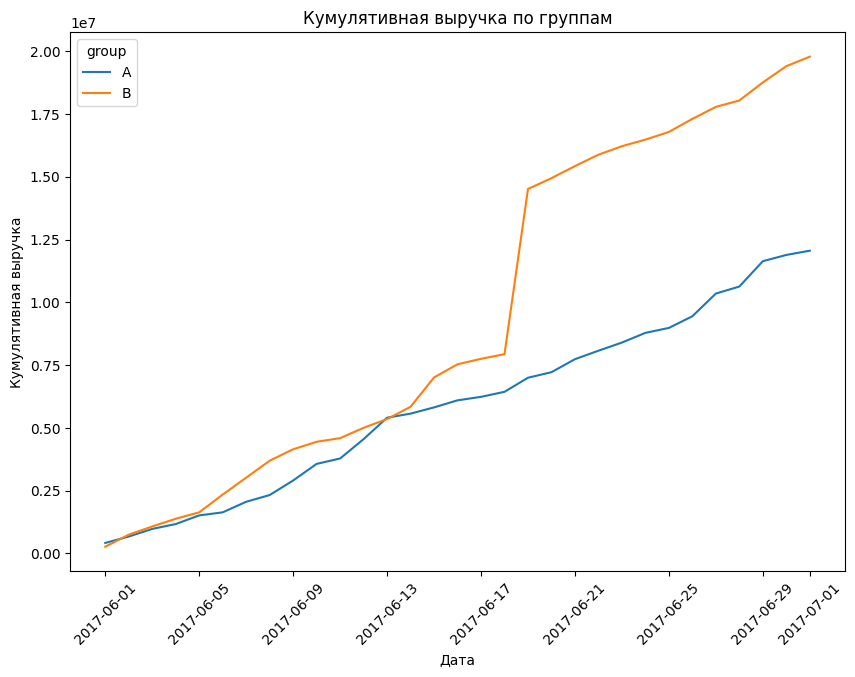

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7]
sns.lineplot(cumulativeData, x="date", y="revenue_cumul", hue="group")
plt.xticks(rotation=45)
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
;

> В течение первой половины месяца выручка по группам значительно не отличалась, однако в районе 18 июня произошел резкий рост выручки у группы **B**. В результате итоговая накопленная выручка группы **B** за все время эксперимента заметно (почти в 2 раза) превышает накопленную выручку группы **A**.

2. Постройте график кумулятивного среднего чека по группам. Опишите выводы

''

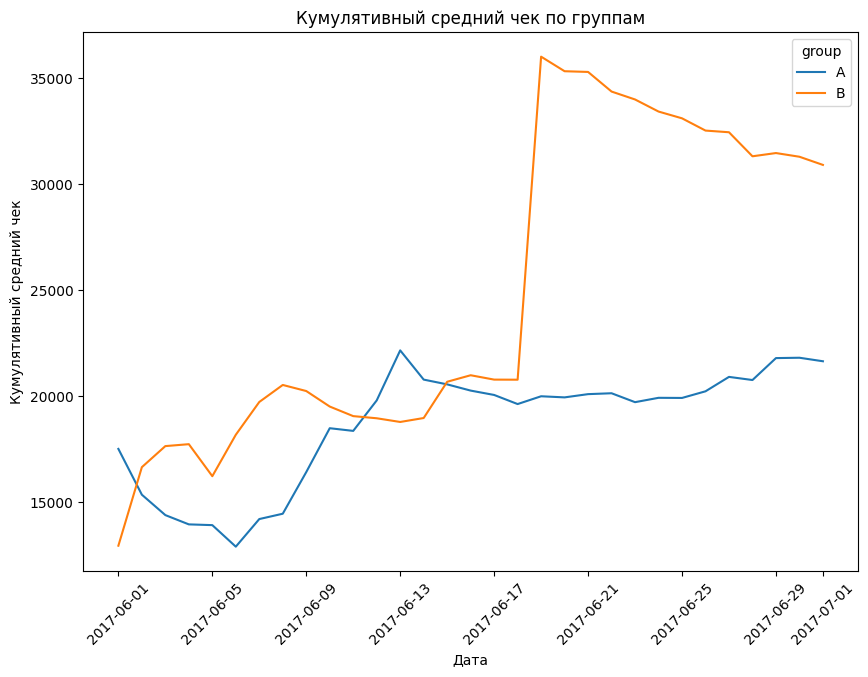

In [ ]:
cumulativeData["aver_bill_cumul"] = (
    cumulativeData["revenue_cumul"] / cumulativeData["orders_count"]
)
sns.lineplot(cumulativeData, x="date", y="aver_bill_cumul", hue="group")
plt.xticks(rotation=45)
plt.title("Кумулятивный средний чек по группам")
plt.xlabel("Дата")
plt.ylabel("Кумулятивный средний чек")
;


> Аналогично кумулятивной выручке, в течение первой половины месяца средний чек по группам значительно не отличался, однако в районе 18 июня произошел резкий рост среднего чека у группы **B**. В результате итоговый накопленный средний чек группы **B** за все время эксперимента заметно превышает значение у группы **A**. Однако в отличии от выручки, в данном случае наблюдается тренд на уменьшение накопленного среднего чека и сближению со значениями для группы **A**. Это может свидетельствовать о необходимости дальнейшего наблюдения.

3. График относительного изменения кумулятивного среднего чека группы B к группе A. Опишите выводы

### Разделим данные для групп A и B, а затем склеим их по датам, чтобы получить отдельные колонки для групп

In [ ]:
cumuldataA = cumulativeData[cumulativeData["group"] == "A"][
    [
        "date",
        "orders_count",
        "unique_users_count",
        "revenue_cumul",
        "users_count",
    ]
]
cumuldataB = cumulativeData[cumulativeData["group"] == "B"][
    [
        "date",
        "orders_count",
        "unique_users_count",
        "revenue_cumul",
        "users_count",
    ]
]
cumuldata_groups = cumuldataA.merge(
    cumuldataB,
    left_on="date",
    right_on="date",
    how="left",
    suffixes=["A", "B"],
)
cumuldata_groups.head()

,date,orders_countA,unique_users_countA,revenue_cumulA,users_countA,orders_countB,unique_users_countB,revenue_cumulB,users_countB
0,2017-06-01,24,20,420253.3,101.6,21,20,271805.0,100.8
1,2017-06-02,44,38,675365.2,188.4,45,43,749183.1,182.0
2,2017-06-03,68,62,978317.6,258.8,61,59,1076192.6,252.7
3,2017-06-04,84,77,1171752.4,360.1,78,75,1383203.6,361.9
4,2017-06-05,109,100,1516585.9,467.3,101,98,1638500.3,461.8


''

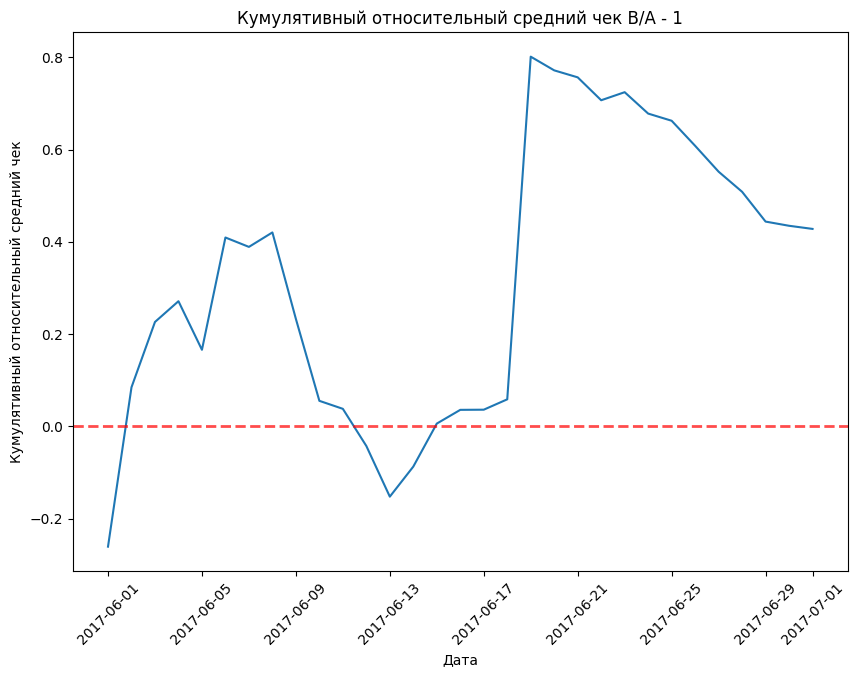

In [ ]:
cumuldata_groups['rel_avg_bill'] = (cumuldata_groups['revenue_cumulB']/cumuldata_groups['orders_countB'])/(cumuldata_groups['revenue_cumulA']/cumuldata_groups['orders_countA']) - 1
sns.lineplot(cumuldata_groups, x="date", y="rel_avg_bill")
plt.xticks(rotation=45)
plt.title("Кумулятивный относительный средний чек B/A - 1")
plt.xlabel("Дата")
plt.ylabel("Кумулятивный относительный средний чек")
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
;

> Выводы аналогичны предыдущему графику.

4. График кумулятивного среднего количества заказов по группам. 

''

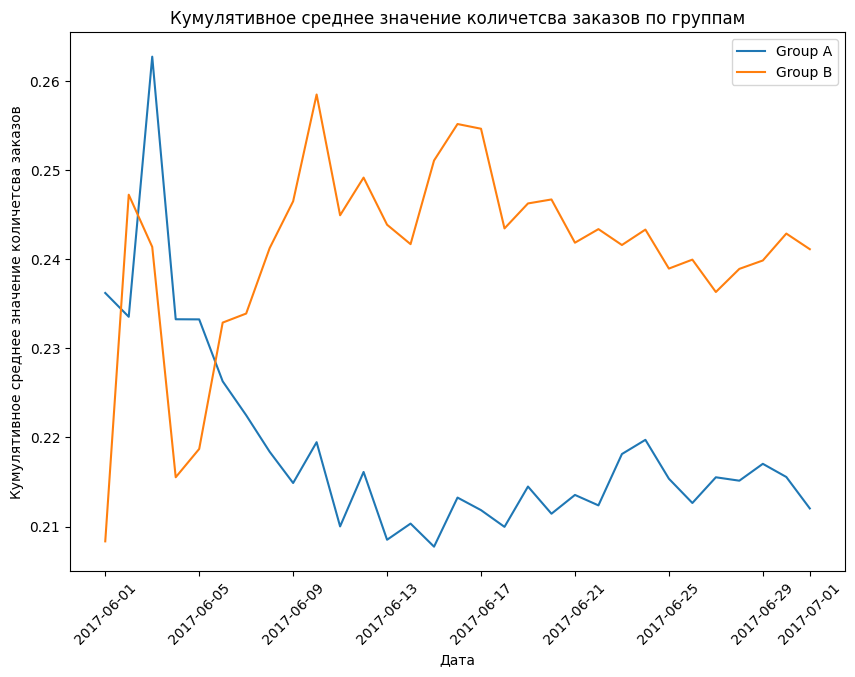

In [ ]:
cumuldata_groups['avg_orders_countA'] = cumuldata_groups['orders_countA']/cumuldata_groups['users_countA']
cumuldata_groups['avg_orders_countB'] = cumuldata_groups['orders_countB']/cumuldata_groups['users_countB']
x = cumuldata_groups['date']
y1 = cumuldata_groups['avg_orders_countA']
y2 = cumuldata_groups['avg_orders_countB']
plt.plot(x, y1, label='Group A')
plt.plot(x, y2, label='Group B')
plt.xticks(rotation=45)
plt.title("Кумулятивное среднее значение количетсва заказов по группам")
plt.xlabel("Дата")
plt.ylabel("Кумулятивное среднее значение количетсва заказов")
plt.legend()
;

5. График относительного изменения кумулятивного среднего количества заказов группы B к группе A

''

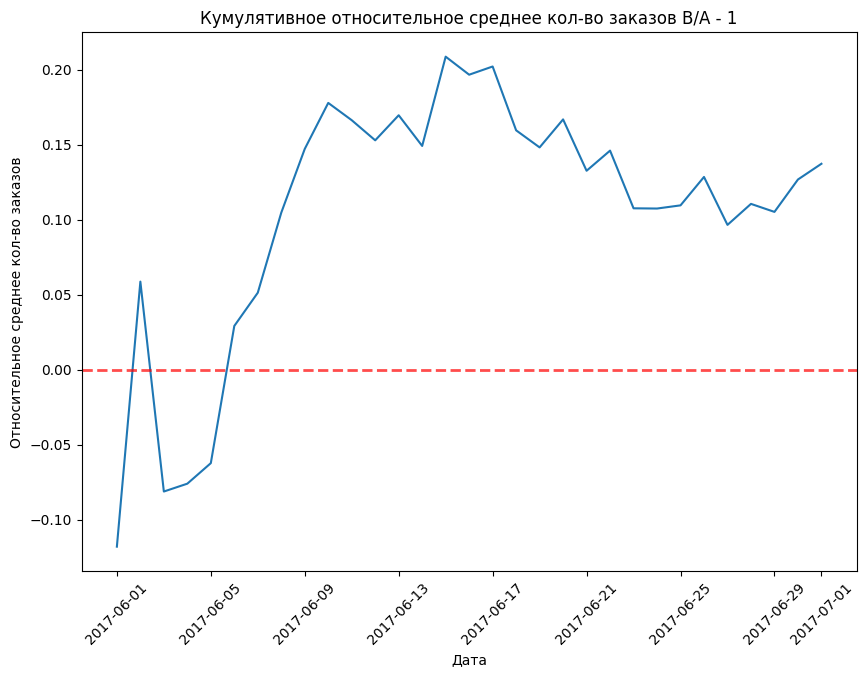

In [ ]:
cumuldata_groups["rel_avg_orders_count"] = (
    cumuldata_groups["avg_orders_countB"] / cumuldata_groups["avg_orders_countA"]
) - 1
sns.lineplot(cumuldata_groups, x="date", y="rel_avg_orders_count")
plt.xticks(rotation=45)
plt.title("Кумулятивное относительное среднее кол-во заказов B/A - 1")
plt.xlabel("Дата")
plt.ylabel("Относительное среднее кол-во заказов")
plt.axhline(y=0, color="red", linestyle="--", linewidth=2, alpha=0.7)
;

6. Распределение количества заказов по пользователям.  Опишите выводы

In [ ]:
transactions["transaction_id"].nunique() == len(transactions["transaction_id"])

True

#### Делаем табличку

In [ ]:
users_orders_count = (
    transactions.groupby("user_id")["transaction_id"].count().copy().reset_index()
)
users_orders_count.columns = ["user_id", "order_count"]
users_orders_count.head()
order_count_dist = users_orders_count.groupby("order_count").count().reset_index()
order_count_dist.columns = ["order_count", "buyers_count"]
# print(np.percentile(users_orders_count, 95))
users_orders_count

2.0


user_id
383057        2
1898805       1
3186559       1
7118851       1
9155481       1
             ..
9913573281    9
9926689559    1
9933344825    3
9934711942    1
9986782319    1
Name: transaction_id, Length: 1031, dtype: int64

#### Строим график

''

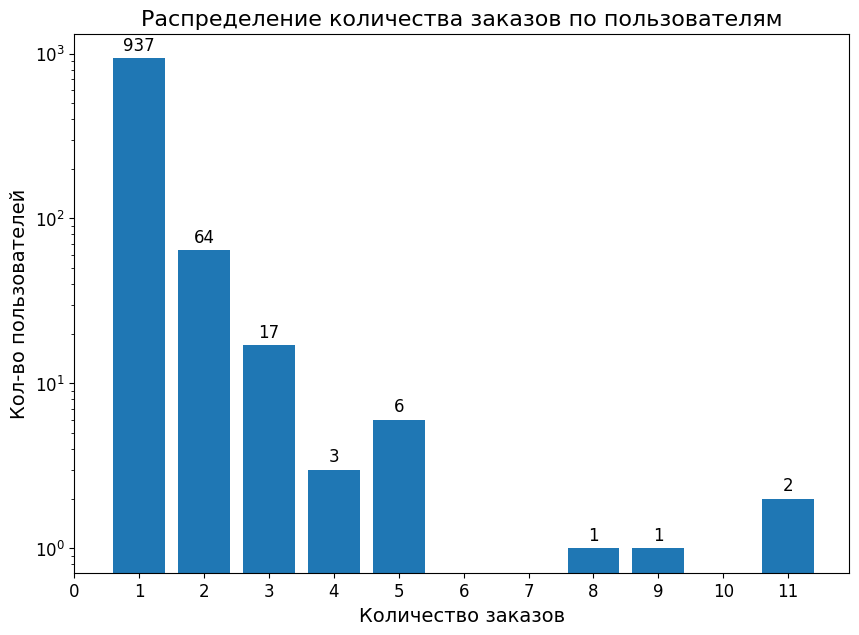

In [ ]:
bars = plt.bar(order_count_dist['order_count'], order_count_dist['buyers_count'])
plt.yscale('log')
plt.title("Распределение количества заказов по пользователям", fontsize=16)
plt.xlabel("Количество заказов", fontsize=14)
plt.ylabel("Кол-во пользователей",fontsize=14)
plt.bar_label(bars, labels=order_count_dist['buyers_count'], padding=3, fontsize=12)
plt.xticks(np.arange(0, 12, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('./figures/task6.png', bbox_inches='tight', dpi=300)
;

7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [ ]:
# Создаем массив в котором количетво заказов будет входить *количество покупателей* раз
orders_count_array = np.repeat(
    order_count_dist["order_count"], order_count_dist["buyers_count"]
)
orders_count_95_perc = np.percentile(orders_count_array, 95)
orders_count_99_perc = np.percentile(orders_count_array, 99)

print("95 перцентиль =", orders_count_95_perc)
print("99 перцентиль =", orders_count_99_perc)

95 перцентиль = 2.0
99 перцентиль = 4.0


> Мне кажется, что границей для определния аномальных пользователей должен быть 99-й перцентиль, так как при выборе 95-го откидывается 20 пользователей из 1000, что составляет 5% от общего числа. При этом эти пользователи делают большое кол-во заказов, т.е. приносят больше прибыли по сравнению со средним пользователем, а значит в "денежном эквиваленте" эти пользователи составляют больше 5% прибыли". Данный факт требует дополнительной проверки.

8. Постройте распределение стоимостей заказов. Сделайте выводы и предположения.

In [ ]:
transactions.head()

,transaction_id,user_id,date,revenue,group
0,6776893763,3392612285,2017-06-15,3758.2,B
1,40289040,8006342366,2017-06-15,1518.7,B
2,1256395556,966904442,2017-06-15,778.4,A
3,4376547739,9761119562,2017-06-15,27081.5,B
4,2237026988,8938272722,2017-06-15,5456.7,B


''

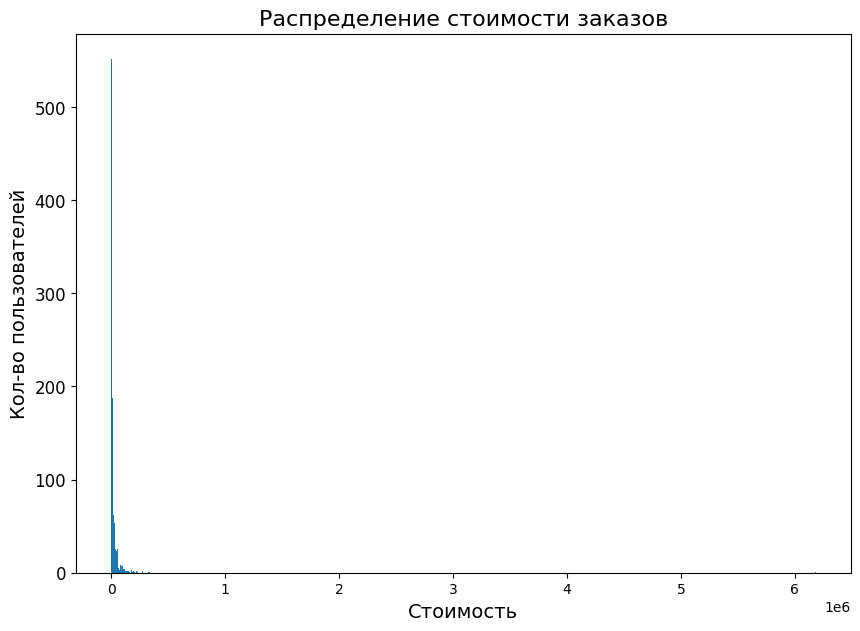

In [ ]:
revenue = transactions["revenue"].astype(float)
plt.hist(revenue, bins = 1000)
# plt.yscale('log')
plt.title("Распределение стоимости заказов", fontsize=16)
plt.xlabel("Стоимость", fontsize=14)
plt.ylabel("Кол-во пользователей",fontsize=14)
plt.yticks(fontsize=12)
plt.savefig('./figures/task8-1.png', bbox_inches='tight', dpi=300)

;


(0.0, 400000.0)

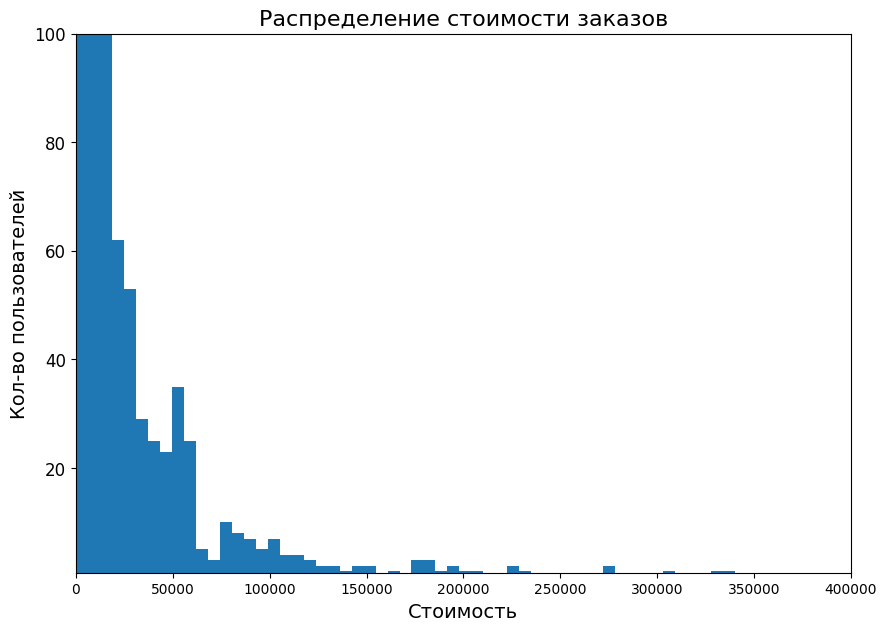

In [ ]:
plt.hist(revenue, bins=1000)
# plt.yscale("log")
plt.title("Распределение стоимости заказов", fontsize=16)
plt.xlabel("Стоимость", fontsize=14)
plt.ylabel("Кол-во пользователей", fontsize=14)
plt.yticks(fontsize=12)
plt.savefig("./figures/task8-2.png", bbox_inches="tight", dpi=300)
plt.ylim(0.7, 100)
plt.xlim(0, 4e5)

9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [ ]:
revenue_95_perc = np.percentile(revenue, 95)
revenue_99_perc = np.percentile(revenue, 99)

print("95 перцентиль =", np.round(revenue_95_perc))
print("99 перцентиль =", np.round(revenue_99_perc))

95 перцентиль = 87355.0
99 перцентиль = 197076.0


10. Посчитайте статистическую значимость различий в среднем количестве заказов между группами по «сырым» данным. Сделайте выводы и предположения.

> Производим операции аналогичные пункту 7, но с разделением на группы

In [276]:
# Для группы B
users_orders_count_B = (
    transactions[transactions["group"] == "B"]
    .groupby("user_id")["transaction_id"]
    .count()
    .copy()
    .reset_index()
)
users_orders_count_B.columns = ["user_id", "order_count"]
# # users_orders_count.head()
order_count_dist_B = users_orders_count_B.groupby("order_count").count().reset_index()
order_count_dist_B.columns = ["order_count", "buyers_count"]
orders_count_array_B = np.repeat(
    order_count_dist_B["order_count"], order_count_dist_B["buyers_count"]
)

orders_count_array_B = np.repeat(
    order_count_dist_B["order_count"], order_count_dist_B["buyers_count"]
)
orders_count_array_B

0    1
0    1
0    1
0    1
0    1
    ..
3    4
3    4
3    4
4    5
5    6
Name: order_count, Length: 586, dtype: int64

In [ ]:
# Для группы A
users_orders_count_A = (
    transactions[transactions["group"] == "A"]
    .groupby("user_id")["transaction_id"]
    .count()
    .copy()
    .reset_index()
)
users_orders_count_A.columns = ["user_id", "order_count"]
# # users_orders_count.head()
order_count_dist_A = users_orders_count_A.groupby("order_count").count().reset_index()
order_count_dist_A.columns = ["order_count", "buyers_count"]
orders_count_array_A = np.repeat(
    order_count_dist_A["order_count"], order_count_dist_A["buyers_count"]
)
orders_count_array_A

0    1
0    1
0    1
0    1
0    1
    ..
3    4
3    4
4    5
4    5
5    7
Name: order_count, Length: 503, dtype: int64

#### Сравниваем массивы для групп **A** и **B**

11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

12. Посчитайте статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным. Сделайте выводы и предположения.

13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

14. Примите решение по результатам теста и объясните его. Варианты решений:   
*  Остановить тест, зафиксировать победу одной из групп.  
*  Остановить тест, зафиксировать отсутствие различий между группами. 